# Data Exploration

Description: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

In [1]:
import matplotlib.pyplot as plt

import matplotlib
from matplotlib import rcParams

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss

%matplotlib inline

In [2]:
import warnings;
with warnings.catch_warnings():
    warnings.simplefilter('ignore'); 

In [3]:
train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json') 

In [4]:
train_df.shape, test_df.shape

((49352, 15), (74659, 14))

In [5]:
train_df.columns

Index([u'bathrooms', u'bedrooms', u'building_id', u'created', u'description',
       u'display_address', u'features', u'interest_level', u'latitude',
       u'listing_id', u'longitude', u'manager_id', u'photos', u'price',
       u'street_address'],
      dtype='object')

In [6]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street


In [7]:
train_df.interest_level.value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

In [8]:
pd.options.display.float_format = '{:,.0f}'.format
train_df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,"49,352","49,352","49,352","49,352","49,352","49,352"
mean,1,2,41,"7,024,055",-74,"3,830"
std,1,1,1,"126,275",1,"22,067"
min,0,0,0,"6,811,957",-118,43
25%,1,1,41,"6,915,888",-74,"2,500"
50%,1,1,41,"7,021,070",-74,"3,150"
75%,1,2,41,"7,128,733",-74,"4,100"
max,10,8,45,"7,753,784",0,"4,490,000"


In [9]:
train_df[train_df.price==43]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
53144,1,0,64f8e51f01a36ab0cd55fe9de2381306,2016-05-24 05:24:56,<p><a website_redacted,Madison,"[Doorman, Elevator, High Speed Internet]",low,41,7060255,-74,29ebd2f6553fbe12706a006a97349dd6,[],43,60 Madison


In [10]:
print 'Min: ', train_df.created.min()
print 'Max: ', train_df.created.max()

Min:  2016-04-01 22:12:41
Max:  2016-06-29 21:41:47


In [11]:
train_df.bathrooms.value_counts()

1     39422
2      7660
3       745
2       645
0       313
2       277
4       159
4        70
4        29
5        20
6         5
6         4
6         1
10        1
7         1
Name: bathrooms, dtype: int64

In [12]:
train_df.bedrooms.value_counts()

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
8        2
7        2
Name: bedrooms, dtype: int64

### Remove outliners from numeric variables

In [13]:
train_df.isnull().sum(axis = 0) # no missing data

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
interest_level     0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

In [14]:
lat_min, lat_max = np.percentile(train_df.latitude, [1, 99]).tolist()
print lat_min, lat_max

train_df['latitude'] = np.where(train_df['latitude'] < lat_min, lat_min,\
                                np.where(train_df['latitude'] > lat_max, lat_max, train_df['latitude']))

40.6404 40.862047


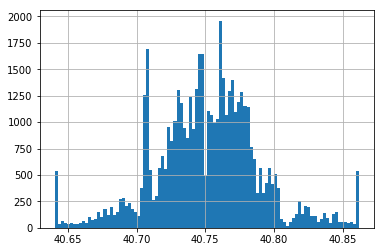

In [15]:
train_df['latitude'].hist(bins = 100)

In [16]:
lon_min, lon_max = np.percentile(train_df.longitude, [1, 99]).tolist()
print lon_min, lon_max

train_df['longitude'] = np.where(train_df['longitude'] < lon_min, lon_min,\
                                 np.where(train_df['longitude'] > lon_max, lon_max, train_df['longitude']))

-74.0162 -73.852651


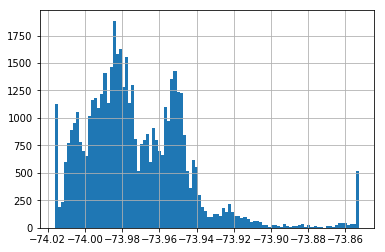

In [17]:
train_df['longitude'].hist(bins = 100)

In [18]:
price_min, price_max = np.percentile(train_df.price, [1, 99]).tolist()
print price_min, price_max

train_df['price'] = np.where(train_df['price'] < price_min, price_min,\
                                 np.where(train_df['price'] > price_max, price_max, train_df['price']))

1475.0 13000.0


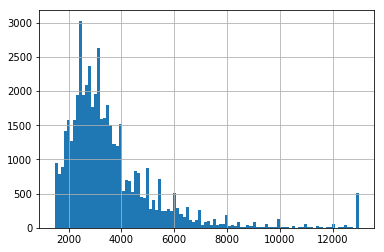

In [19]:
train_df.price.hist(bins = 100)

In [20]:
train_df.groupby('interest_level').price.count()

interest_level
high       3839
low       34284
medium    11229
Name: price, dtype: int64

In [21]:
train_df.groupby('interest_level').price.median()

interest_level
high     2,400
low      3,300
medium   2,895
Name: price, dtype: float64

### Cleaning up character variables

In [22]:
train_df['display_address'].value_counts()[:20]

Broadway              438
East 34th Street      355
Second Avenue         349
Wall Street           332
West 37th Street      287
West Street           258
First Avenue          244
Gold Street           241
Washington Street     237
York Avenue           228
John Street           214
Water Street          214
East 39th Street      200
East 89th Street      195
West 54th Street      193
Lexington Avenue      189
Fifth Avenue          189
West 42nd Street      184
Christopher Street    180
Third Avenue          178
Name: display_address, dtype: int64

In [23]:
import unicodedata
import re

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii

In [24]:
train_df['display_address_clean'] = [remove_accents(line) for line in train_df['display_address']] 

In [25]:
pd.DataFrame(train_df['display_address_clean'].unique()).to_csv('display_address_ascii.csv')

In [26]:
train_df['display_address_clean'] = train_df.display_address.map(lambda x: ' '.join(x.strip('-,.$*!#&\'\t')\
                                                    .replace("'",'').lower()\
                                                    .replace(' street', ' st').replace(' avenue', ' ave')\
                                                    .replace(' road', ' rd').replace(' boulevard', ' blvd')\
                                                    .replace(' east', ' e').replace(' west', ' w').split()))
train_df['display_address_clean'].value_counts()[:20]

wall st           451
broadway          443
west st           401
second ave        370
east 34th st      358
john st           346
gold st           345
york ave          316
washington st     304
columbus ave      292
west 37th st      289
lexington ave     283
water st          280
first ave         268
thompson st       238
christopher st    226
amsterdam ave     212
west end ave      208
2nd ave           204
third ave         203
Name: display_address_clean, dtype: int64

In [27]:
train_df['display_address_clean'].value_counts()[:20]

wall st           451
broadway          443
west st           401
second ave        370
east 34th st      358
john st           346
gold st           345
york ave          316
washington st     304
columbus ave      292
west 37th st      289
lexington ave     283
water st          280
first ave         268
thompson st       238
christopher st    226
amsterdam ave     212
west end ave      208
2nd ave           204
third ave         203
Name: display_address_clean, dtype: int64

In [28]:
features_list = []
for i in range(len(train_df)):
    alist = train_df.features.values[i]
    for x in alist:
        features_list.append(x)

In [29]:
len(features_list), len(set(features_list))

(267906, 1556)

In [30]:
sorted(set(features_list))[:20]

[u'!!!!LOW FEE!!!!',
 u'$1000. Move-in Visa Giftcard will be handed to new tenants upon rental lease signing',
 u'$1500. Move-in Visa Giftcard will be handed to new tenants upon rental lease signing',
 u'$250 Security Deposit',
 u'$250 application fee with background and credit check. Board interview and approval.',
 u'$500 Security Deposit',
 u'$600 gift card for Move-ins prior to June 19',
 u'& ATM machine on-site',
 u'* MARVELOUS MIDTOWN GEM * SPACIOUS SUNDRENCHED STUDIO * STUNNING PREWAR DETAILS * CATS OK **',
 u"** ALL BRAND NEW NO FEE! * EXPANSIVE 2BR McMANSION * PRIVATE TERRACE * COOK'S SS KITCHEN * ELEV/LNDRY BLDG * 3 BLKS TO L TRAIN **",
 u"** BKLYN'S FINEST! * MASSIVE TRUE 2BR * COURTYARD * FULLY RENOVATED * 2 BLKS TO BEDFORD L STOP **",
 u"** BRAND SPANKIN' NEW * OVERSIZED 3BR HOME * WASHER/DRYER * SS KITCHEN w/ISLAND * HEART OF DESIRABLE SOHO **",
 u"** BRING UR BBQ! * SPRAWLING 2BR HOME * HUGE REAR TERRACE * MODERN EVERYTHING * CHEF'S KITCHEN * ALL NEW **",
 u'** BROWNSTON

In [31]:
train_df['features_clean'] = [[remove_accents(item) for item in line] for line in train_df['features']]

In [32]:
train_df['features_clean'].to_csv("features_ascii.csv")

The most relevant: bathrooms, bedrooms, price. 

Unrelevant: building_id, created, manager_id.

Let's convert some features to more useful:

In [33]:
def add_features(df):
    df['num_photos'] = df['photos'].apply(len)
    df['num_features'] = df['features'].apply(len)
    df['description_size'] = df['description'].apply(lambda x: len(x.split(" ")))
    df['created'] = pd.to_datetime(df['created'])
    df['created_day'] = df['created'].dt.day
    df['created_month'] = df['created'].dt.month
    df['hod'] = df['created'].dt.hour
    df['dow'] = df['created'].dt.dayofweek

In [34]:
add_features(train_df)
add_features(test_df)

In [35]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,street_address,display_address_clean,features_clean,num_photos,num_features,description_size,created_day,created_month,hod,dow
10,2,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,41,7211212,...,792 Metropolitan Avenue,metropolitan ave,[],5,0,95,24,6,7,4
10000,1,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,41,7150865,...,808 Columbus Avenue,columbus ave,"[Doorman, Elevator, Fitness Center, Cats Allow...",11,5,9,12,6,12,6
100004,1,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,41,6887163,...,241 W 13 Street,w 13 st,"[Laundry In Building, Dishwasher, Hardwood Flo...",8,4,94,17,4,3,6


https://www.kaggle.com/shubh24/two-sigma-connect-rental-listing-inquiries/neighborhood-as-factor-reverse-geocoding - NOT ALLOWED in kaggle

In [36]:
# https://github.com/thampiman/reverse-geocoder
import reverse_geocoder as rg

In [37]:
train_coordinates = train_df[['listing_id', 'latitude', 'longitude']]

# Reverse Geocoder takes a list of tuples (of latitude and longitude) as its input.
lat_lon = []
listings = []

for i, j in train_coordinates.iterrows():
    lat_lon.append((j['latitude'], j['longitude']))
    listings.append(int(j['listing_id']))

In [38]:
results = rg.search(lat_lon)
# nbd = [[listings[i], results[i]['name']] for i in range(0, len(results))]

Loading formatted geocoded file...


In [39]:
# train_df['neighborhood']=''
for i in range(0, len(results)):
    train_df.loc[train_df['listing_id'] ==listings[i], 'neighborhood'] = results[i]['name']

In [40]:
train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,display_address_clean,features_clean,num_photos,num_features,description_size,created_day,created_month,hod,dow,neighborhood
10,2,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,41,7211212,...,metropolitan ave,[],5,0,95,24,6,7,4,Long Island City
10000,1,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,41,7150865,...,columbus ave,"[Doorman, Elevator, Fitness Center, Cats Allow...",11,5,9,12,6,12,6,Manhattan
100004,1,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,41,6887163,...,w 13 st,"[Laundry In Building, Dishwasher, Hardwood Flo...",8,4,94,17,4,3,6,New York City


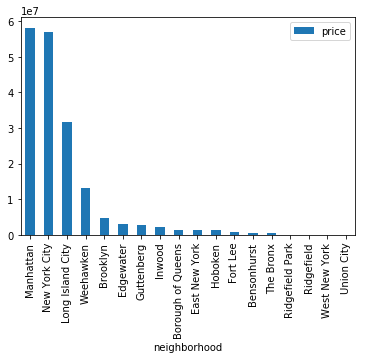

In [41]:
train_df.groupby('neighborhood').agg({'price':sum}).sort_values(by='price', ascending=False).plot(kind='bar')

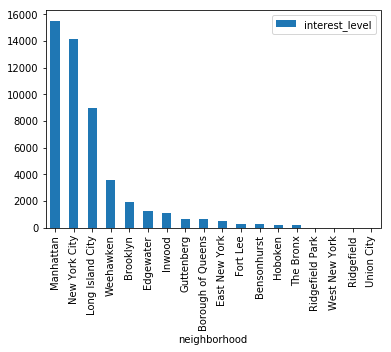

In [42]:
train_df.groupby('neighborhood').agg({'interest_level':'count'}).sort_values(by='interest_level', ascending=False).plot(kind='bar')

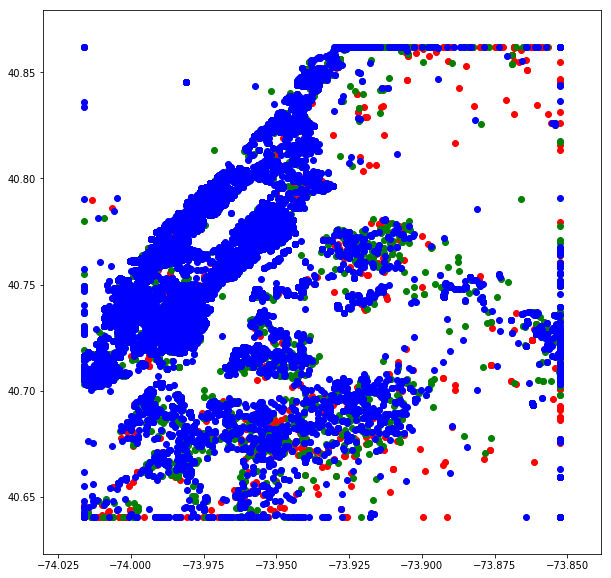

In [43]:
plt.figure(figsize=(10, 10))

train_df_high = train_df[train_df['interest_level']=='high']
train_df_medium = train_df[train_df['interest_level']=='medium']
train_df_low = train_df[train_df['interest_level']=='low']

plt.scatter(train_df_high.longitude, train_df_high.latitude, color='r')
plt.scatter(train_df_medium.longitude, train_df_medium.latitude, color='g')
plt.scatter(train_df_low.longitude, train_df_low.latitude, color='b')

# Training

In [44]:
my_features = ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 
               'num_photos', 'num_features', 'description_size', 'hod', 'dow']

X = train_df[my_features]
y = train_df['interest_level']

X.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,description_size,hod,dow
10,2,3,41,-74,"3,000",5,0,95,7,4
10000,1,2,41,-74,"5,465",11,5,9,12,6
100004,1,1,41,-74,"2,850",8,4,94,3,6
100007,1,1,41,-74,"3,275",3,2,80,2,0
100013,1,4,41,-74,"3,350",3,1,68,1,3


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [46]:
%%time
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print('LogisticRegression score: %f' % logistic.score(X_test, y_test))

LogisticRegression score: 0.694762
CPU times: user 955 ms, sys: 13.3 ms, total: 969 ms
Wall time: 970 ms


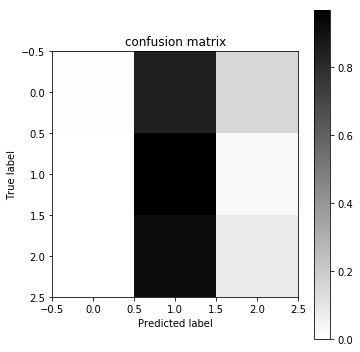

In [47]:
plt.figure(figsize=(5, 5))
cm = confusion_matrix(y_test, logistic.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.binary)
plt.title('confusion matrix')
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('confusion_matrix.png', dpi=200)

In [48]:
%%time
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
print('RandomForestClassifier score: %f' % clf.score(X_test, y_test))

# prev: 0.733259

RandomForestClassifier score: 0.731638
CPU times: user 1min 2s, sys: 1.37 s, total: 1min 3s
Wall time: 1min 4s


In [49]:
y_prediction = clf.predict_proba(X_test)
log_loss(y_test, y_prediction)

0.61563887763775704

In [50]:
X = train_df[my_features]
y = clf.predict_proba(X)

# Submission saving

In [51]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

{u'high': 0, u'low': 1, u'medium': 2}

In [52]:
submission = pd.DataFrame()
submission['listing_id'] = train_df['listing_id']
for label in ['high', 'medium', 'low']:
    submission[label] = y[:, labels2idx[label]]
submission.to_csv('submission.csv', index=False)

In [53]:
submission.head()

,listing_id,high,medium,low
10,7211212,0,1,0
10000,7150865,0,0,1
100004,6887163,1,0,0
100007,6888711,0,0,1
100013,6934781,0,0,1
